In [397]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import quapy as qp
from quapy.error import kld
from quapy.method.aggregative import (
    CC,
    ACC,
    PCC,
    PACC,
    MAX as TH_MAX,
    X as TH_X,
    T50 as TH_T50,
    MS as TH_MS,
    EMQ,
    HDy,
    newELM,
)
from quapy.functional import HellingerDistance
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [398]:
output_dir = 'plots_teoria'

# Capítulo 1: Problema

## 1.1. Introducción

In [399]:
train_size = 250
prev_test = 0.1

In [400]:
population_size = int(train_size * 1.4)
population_config = {
    'n_samples': population_size,
    'class_sep': 0.2,
    'n_classes': 2,
    'n_features': 3,
    'n_informative': 2,
    'n_redundant': 0,
    'n_repeated': 0,
}
random_state = 42
np.random.seed(random_state)

In [401]:
X, y = make_classification(
    **population_config,
    weights=None,
    random_state=random_state,
)

In [402]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
idx_negatives_test = np.argwhere(y_test==0).flatten()
idx_positives_test = np.random.choice(
    np.argwhere(y_test==1).flatten(),
    size=round((prev_test)*len(idx_negatives_test)/(1-prev_test)),
    replace=False,
)
idx_test = np.concatenate([idx_positives_test, idx_negatives_test])
X_test = X_test[idx_test]
y_test = y_test[idx_test]

In [403]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [404]:
y_predict_train = model.predict(X_train)
positive_predictions_train = (y_predict_train==1)

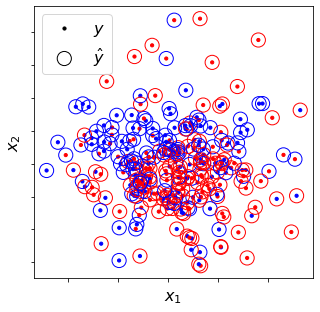

In [405]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 16

ground_truth_colors_train = np.where(y_train, 'r', 'b')
ground_truth_points_train = ax.scatter(
    x=X_train[:, 0],
    y=X_train[:, 1],
    s=40,
    c=ground_truth_colors_train,
    marker='.',
)
prediction_colors_test = np.where(y_predict_train, 'r', 'b')
prediction_circles_test = ax.scatter(
    x=X_train[:, 0],
    y=X_train[:, 1],
    s=200,
    marker='o',
    facecolors='None',
    edgecolors=prediction_colors_test,
)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel(r'$x_{1}$', fontsize=fontsize)
plt.ylabel(r'$x_{2}$', fontsize=fontsize)
ax.legend(
    [ground_truth_points_train, prediction_circles_test],
    [r'$y$', r'$\hat y$'],
    loc='best',
    fontsize=fontsize,
)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')
plt.savefig(f'{output_dir}/intro_scatterplot.png')
plt.show()

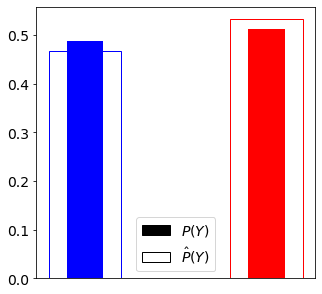

In [406]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 14

unique, y_train_counts = np.unique(y_train, return_counts=True)
_, y_train_predict_counts = np.unique(y_predict_train, return_counts=True)

ax.xaxis.set_visible(False)
colors = ['blue', 'red']
ground_truth_bar = ax.bar(
    unique,
    y_train_counts/len(y_train),
    color=colors,
    width=0.2,
)
predictions_bar = ax.bar(
    unique,
    y_train_predict_counts/len(y_train),
    edgecolor=colors,
    width=0.4, 
    fill=False,
)
ax.legend(
    [ground_truth_bar, predictions_bar],
    [r'$P(Y)$', r'$\hat P(Y)$'],
    fontsize=fontsize,
    loc='best',
)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')
plt.yticks(fontsize=fontsize)
plt.savefig(f'{output_dir}/intro_barplot.png')
plt.show()

## 1.4. Cambios en las distribuciones de los datos

In [407]:
y_predict_test = model.predict(X_test)
positive_predictions_test = (y_predict_test==1)

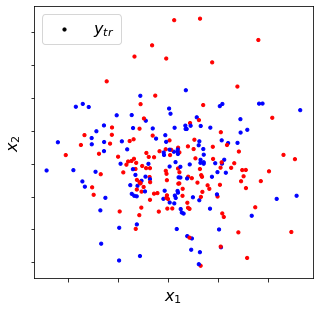

In [408]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 16

ground_truth_colors_train = np.where(y_train, 'r', 'b')
ground_truth_points_train = ax.scatter(
    x=X_train[:, 0],
    y=X_train[:, 1],
    s=40,
    c=ground_truth_colors_train,
    marker='.',
)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel(r'$x_{1}$', fontsize=fontsize)
plt.ylabel(r'$x_{2}$', fontsize=fontsize)
ax.legend(
    [ground_truth_points_train],
    [r'$y_{tr}$'],
    loc='best',
    fontsize=fontsize,
)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
plt.savefig(f'{output_dir}/cambios_train_scatterplot.png')
plt.show()

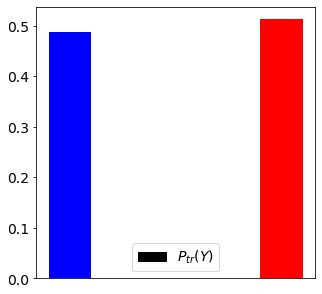

In [409]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 14

unique, y_counts_train = np.unique(y_train, return_counts=True)

ax.xaxis.set_visible(False)
colors = ['blue', 'red']
ground_truth_bar = ax.bar(
    unique,
    y_counts_train/len(y_train),
    color=colors,
    width=0.2,
)
ax.legend(
    [ground_truth_bar],
    [r'$P_{tr}(Y)$'],
    loc='best',
    fontsize=fontsize,
)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
plt.yticks(fontsize=fontsize)
plt.savefig(f'{output_dir}/cambios_train_barplot.png')
plt.show()

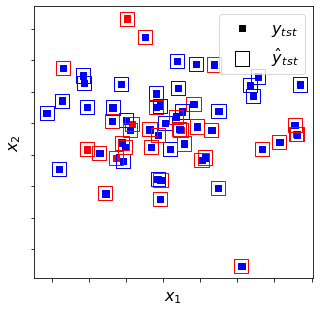

In [410]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 16

ground_truth_colors_test = np.where(y_test, 'r', 'b')
ground_truth_points_test = ax.scatter(
    x=X_test[:, 0],
    y=X_test[:, 1],
    s=40,
    c=ground_truth_colors_test,
    marker='s',
)
prediction_colors_test = np.where(y_predict_test, 'r', 'b')
predictions_squares_test = ax.scatter(
    x=X_test[:, 0],
    y=X_test[:, 1],
    s=200,
    marker='s',
    facecolors='None',
    edgecolors=prediction_colors_test,
)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel(r'$x_{1}$', fontsize=fontsize)
plt.ylabel(r'$x_{2}$', fontsize=fontsize)
ax.legend(
    [ground_truth_points_test, predictions_squares_test],
    [r'$y_{tst}$', r'$\hat y_{tst}$'],
    loc='best',
    fontsize=fontsize,
)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')
plt.savefig(f'{output_dir}/cambios_test_scatterplot.png')
plt.show()

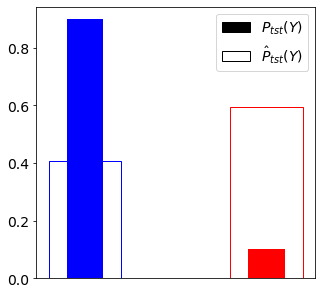

In [411]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 14

_, y_counts_test = np.unique(y_test, return_counts=True)
_, y_counts_predict_test = np.unique(y_predict_test, return_counts=True)

ax.xaxis.set_visible(False)
colors = ['blue', 'red']
ground_truth_bar = ax.bar(
    unique,
    y_counts_test/len(y_test),
    color=colors,
    width=0.2,
)
predictions_bar = ax.bar(
    unique,
    y_counts_predict_test/len(y_test),
    edgecolor=colors,
    width=0.4, 
    fill=False,
)
ax.legend(
    [ground_truth_bar, predictions_bar],
    [r'$P_{tst}(Y)$', r'$\hat P_{tst}(Y)$'],
    loc='best',
    fontsize=fontsize,
)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')
plt.yticks(fontsize=fontsize)
plt.savefig(f'{output_dir}/cambios_test_barplot.png')
plt.show()

## 1.5. El problema de clasificar y contar

In [412]:
p_vals = np.round(np.arange(0, 1.05, 0.05), 2)
tpr_vals = np.round(np.arange(0.6, 1.01, 0.2), 1)
fpr_vals = np.round(np.arange(0, 0.41, 0.2), 1)

In [413]:
# Compute the formula for all possible combinations using broadcasting
p_hat_vals = (
    p_vals[:, np.newaxis, np.newaxis] * tpr_vals[np.newaxis, :, np.newaxis] +
    (1-p_vals[:, np.newaxis, np.newaxis])*fpr_vals[np.newaxis, np.newaxis, :]
)

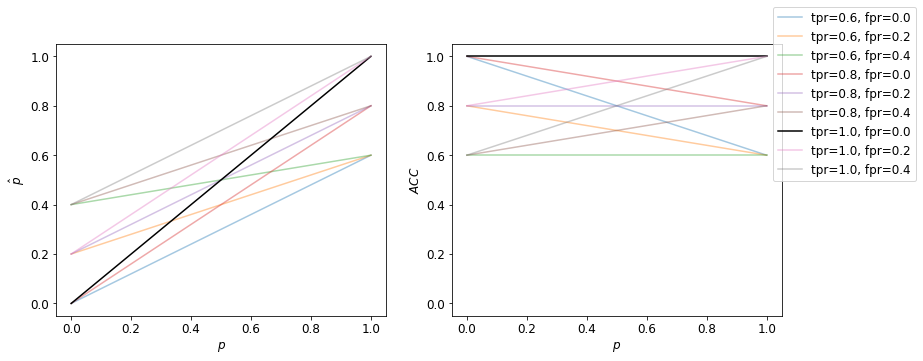

In [414]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(13, 5)
fontsize = 12
default_alpha = 0.4
loc = plticker.MultipleLocator(base=0.1)

for i in range(0, len(tpr_vals)):
    for j in range(0, len(fpr_vals)):
        alpha = default_alpha
        color = None
        if tpr_vals[i]==1 and fpr_vals[j]==0:
            alpha = 1
            color = 'black'
        ax1.plot(
            p_vals,
            p_hat_vals[:, i, j],
            label=f'tpr={tpr_vals[i]:.1f}, fpr={fpr_vals[j]:.1f}',
            alpha=alpha,
            color=color,
        )
ax1.set_xlabel(r'$p$', fontsize = fontsize)
ax1.set_ylabel(r'$\hat p$', fontsize = fontsize)
ax1.tick_params(labelsize = fontsize)

for i in range(0, len(tpr_vals)):
    for j in range(0, len(fpr_vals)):
        alpha = default_alpha
        color = None
        if tpr_vals[i]==1 and fpr_vals[j]==0:
            alpha = 1
            color = 'black'
        ax2.plot(
            p_vals,
            (tpr_vals[i]*p_vals)+(1-fpr_vals[j])*(1-p_vals),
            label=f'tpr={tpr_vals[i]:.1f}, fpr={fpr_vals[j]:.1f}',
            alpha=alpha,
            color=color,
        )
ax2.set_xlabel(r'$p$', fontsize = fontsize)
ax2.set_ylabel(r'$ACC$', fontsize = fontsize)
ax2.tick_params(labelsize = fontsize)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
handles, labels = ax1.get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(1.05, 1), fontsize=fontsize)

plt.savefig(f'{output_dir}/cc_tpr_fpr.png', bbox_inches='tight')
plt.show()

# Capítulo 2: Estimación Puntual

In [415]:
X_ab, X_c, y_ab, y_c = train_test_split(X_train, y_train, test_size = 0.15, random_state=random_state)
X_a, X_b, y_a, y_b = train_test_split(X_ab, y_ab, test_size = 0.176, random_state=random_state) # 0.85*0.176=0.15
# a: 70%, b: 15%, c: 15%

In [416]:
#CC:
## No necesita dataset para calibrar ni cuantificar
### Cuantifico
#### Manualmente
hat_p_cc = y_counts_predict_test[1]/len(y_test)
#### Con QuaPy
hat_p_cc_qp = CC(model).aggregate(y_predict_test)[1]
### Resultados
{
    'frac': f"{y_counts_predict_test[1]}/{len(y_test)}",
    'hat_p_cc': hat_p_cc,
    'hat_p_cc_qp': hat_p_cc_qp,
}

{'frac': '35/59',
 'hat_p_cc': 0.5932203389830508,
 'hat_p_cc_qp': 0.5932203389830508}

In [417]:
#ACC:
## Necesita dataset para cuantificar
### Creo nuevo modelo con 85% de datos, y predigo para test set
model = GaussianNB()
model.fit(X_ab, y_ab)
y_predict_test = model.predict(X_test)
_, y_counts_predict_test = np.unique(y_predict_test, return_counts=True)
hat_p_cc = y_counts_predict_test[1]/len(y_test)
### Ajusto modelo cuantificador con el 15%
#### Manualmente
y_predict_c = model.predict(X_c)
tn, fp, fn, tp = confusion_matrix(y_c, y_predict_c).ravel()
print({
    "tn": tn,
    "fp": fp,
    "fn": fn,
    "tp": tp,
})
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)
### Cuantifico
hat_p_acc = (hat_p_cc-fpr)/(tpr-fpr)
#### Con QuaPy
classif_predictions = qp.data.LabelledCollection(y_predict_c, y_c)
qp_tr_data = classif_predictions
qp_acc = ACC(model)
qp_acc.aggregation_fit(classif_predictions, qp_tr_data)
### Cuantifico
hat_p_acc_qp = qp_acc.aggregate(y_predict_test)[1]
### Resultados
{
    "fpr": fpr,
    "tpr": tpr,
    'hat_p_cc': hat_p_cc,
    "hat_p_acc": hat_p_acc,
    'hat_p_acc_qp': hat_p_acc_qp,
}

{'tn': 13, 'fp': 8, 'fn': 4, 'tp': 13}


{'fpr': 0.38095238095238093,
 'tpr': 0.7647058823529411,
 'hat_p_cc': 0.559322033898305,
 'hat_p_acc': 0.4648026722751453,
 'hat_p_acc_qp': 0.4648037663326138}

In [418]:
#PCC
## Necesita dataset para calibrar
### Creo nuevo modelo con 85% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_ab, y_ab)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_c, y_c)
y_predict_proba_test = model.predict_proba(X_test)
s = pd.DataFrame(y_predict_proba_test).transpose()
print(s.to_latex(
    header=False,
    bold_rows=True,
    float_format="%.2f",
))
### Cuantifico
#### Manualmente
hat_p_pcc = y_predict_proba_test[:, 1].sum()/len(y_test)
#### Con QuaPy
hat_p_pcc_qp = PCC(model).aggregate(y_predict_proba_test)[1]
### Resultados
{
    'hat_p_pcc': hat_p_pcc,
    'hat_p_pcc_qp': hat_p_pcc_qp,
}

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
\textbf{0} & 0.31 & 0.36 & 0.51 & 0.43 & 0.42 & 0.47 & 0.52 & 0.60 & 0.82 & 0.13 & 0.42 & 0.78 & 0.27 & 0.76 & 0.58 & 0.32 & 0.65 & 0.49 & 0.27 & 0.39 & 0.77 & 0.45 & 0.43 & 0.48 & 0.44 & 0.85 & 0.47 & 0.63 & 0.68 & 0.53 & 0.71 & 0.66 & 0.39 & 0.58 & 0.46 & 0.34 & 0.45 & 0.79 & 0.42 & 0.75 & 0.25 & 0.46 & 0.23 & 0.63 & 0.57 & 0.79 & 0.86 & 0.20 & 0.84 & 0.66 & 0.52 & 0.75 & 0.54 & 0.46 & 0.68 & 0.35 & 0.81 & 0.81 & 0.76 \\
\textbf{1} & 0.69 & 0.64 & 0.49 & 0.57 & 0.58 & 0.53 & 0.48 & 0.40 & 0.18 & 0.87 & 0.58 & 0.22 & 0.73 & 0.24 & 0.42 & 0.68 & 0.35 & 0.51 & 0.73 & 0.61 & 0.23 & 0.55 & 0.57 & 0.52 & 0.56 & 0.15 & 0.53 & 0.37 & 0.32 & 0.47 & 0.29 & 0.34 & 0.61 & 0.42 & 0.54 & 0.66 & 0.55 & 0.21 & 0.58 & 0.25 & 0.75 & 0.54 & 0.77 & 0.37 & 0.43 & 0.21 & 0.14 & 0.80 & 0.16 & 0.34 & 0.48 & 0.25 & 0.46 & 0.54 & 0.32 & 0.65 & 0.19 & 0.19 & 0.24 \\
\bottomrule
\end{tabular}



{'hat_p_pcc': 0.4591418072300529, 'hat_p_pcc_qp': 0.45914180723005277}

In [419]:
#PACC
## Necesita dataset para cuantificar y para calibrar
### Creo nuevo modelo con 60% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_a, y_a)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_b, y_b)
y_predict_proba_test = model.predict_proba(X_test)
hat_p_pcc = y_predict_proba_test[:, 1].sum()/len(y_test)
### Ajusto modelo cuantificador con el 15%
#### Manualmente
y_predict_c = model.predict(X_c)
y_predict_proba_c = model.predict_proba(X_c)
s = pd.DataFrame({
    "h(x)=0": y_predict_proba_c[:, 0],
    "h(x)=1": y_predict_proba_c[:, 1],
    "y": y_predict_c,
})
print(s.to_latex(
    index=False,
    float_format="%.2f",
))
tppa = y_predict_proba_c[y_c==1, 1].sum()/(y_c==1).sum()
fppa = y_predict_proba_c[y_c==0, 1].sum()/(y_c==0).sum()
#### Cuantifico
hat_p_pacc = (hat_p_pcc-fppa)/(tppa-fppa)
#### Con QuaPy
classif_predictions = qp.data.LabelledCollection(y_predict_proba_c, y_c)
qp_tr_data = classif_predictions
qp_pacc = PACC(model)
qp_pacc.aggregation_fit(classif_predictions, qp_tr_data)
#### Cuantifico
hat_p_pacc_qp = qp_pacc.aggregate(y_predict_proba_test)[1]
### Resultados
{
    "tppa": tppa,
    "fppa": fppa,
    'hat_p_pcc': hat_p_pcc,
    "hat_p_pacc": hat_p_pacc,
    'hat_p_pacc_qp': hat_p_pacc_qp,
}

\begin{tabular}{rrr}
\toprule
 h(x)=0 &  h(x)=1 &  y \\
\midrule
   0.57 &    0.43 &  0 \\
   0.40 &    0.60 &  1 \\
   0.50 &    0.50 &  1 \\
   0.39 &    0.61 &  1 \\
   0.42 &    0.58 &  1 \\
   0.44 &    0.56 &  1 \\
   0.58 &    0.42 &  0 \\
   0.44 &    0.56 &  1 \\
   0.53 &    0.47 &  0 \\
   0.55 &    0.45 &  0 \\
   0.46 &    0.54 &  1 \\
   0.40 &    0.60 &  1 \\
   0.49 &    0.51 &  1 \\
   0.49 &    0.51 &  1 \\
   0.46 &    0.54 &  1 \\
   0.44 &    0.56 &  1 \\
   0.40 &    0.60 &  1 \\
   0.53 &    0.47 &  0 \\
   0.41 &    0.59 &  1 \\
   0.31 &    0.69 &  1 \\
   0.46 &    0.54 &  1 \\
   0.33 &    0.67 &  1 \\
   0.43 &    0.57 &  1 \\
   0.54 &    0.46 &  0 \\
   0.35 &    0.65 &  1 \\
   0.50 &    0.50 &  1 \\
   0.55 &    0.45 &  0 \\
   0.46 &    0.54 &  1 \\
   0.51 &    0.49 &  0 \\
   0.48 &    0.52 &  1 \\
   0.36 &    0.64 &  1 \\
   0.57 &    0.43 &  0 \\
   0.46 &    0.54 &  1 \\
   0.36 &    0.64 &  1 \\
   0.40 &    0.60 &  1 \\
   0.37 &    0.63 &  1 \\

{'tppa': 0.5807460071887866,
 'fppa': 0.5180321302766103,
 'hat_p_pcc': 0.5551286486459186,
 'hat_p_pacc': 0.5915200940496439,
 'hat_p_pacc_qp': 0.5915200936076177}

In [420]:
# Seleccion de umbrales
## Necesita dataset para cuantificar y para calibrar
### Mantengo el modelo de PACC
### Ajusto modelo cuantificador con el 15%
fprs, tprs, ths = roc_curve(y_c, y_predict_proba_c[:, 1])

idx_dict = {}
th_dict = {}
tpr_dict = {}
fpr_dict = {}

idx_dict['MAX'] = np.argmax(tprs - fprs)
max_val = np.max(tprs - fprs)
idx_dict['X'] = np.argmin(np.abs(np.array(fprs + tprs)-1))
idx_dict['T50'] = np.argmin(np.abs(np.array(tprs)-0.5))

for key, val in idx_dict.items():
    th_dict[key] = ths[val]
    fpr_dict[key] = fprs[val]
    tpr_dict[key] = tprs[val]

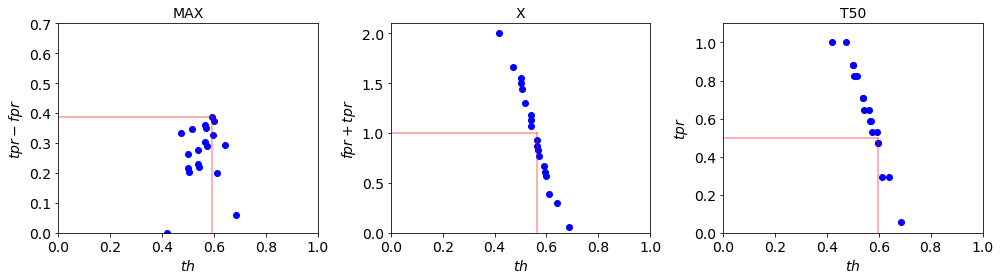

Thresholds:  {'MAX': 0.5917493242702864, 'X': 0.5640429199730439, 'T50': 0.5985384557470071}


In [421]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(14, 4)
fontsize = 14
alpha = 0.4

ax1.plot(
    ths,
    tprs - fprs,
    'o',
    color='b',
)
ax1.plot(
    [0, th_dict['MAX']],
    [max_val, max_val],
    alpha=alpha,
    color='r',
)
ax1.plot(
    [th_dict['MAX'], th_dict['MAX']],
    [0, max_val],
    alpha=alpha,
    color='r',
)
ax1.set_xlabel(r'$th$', fontsize = fontsize)
ax1.set_ylabel(r'$tpr - fpr$', fontsize = fontsize)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 0.7])
ax1.tick_params(labelsize = fontsize)
ax1.set_title('MAX', fontsize = fontsize)

ax2.plot(
    ths,
    fprs + tprs,
    'o',
    color='b',
)
ax2.plot(
    [0, th_dict['X']],
    [1, 1],
    alpha=alpha,
    color='r',
)
ax2.plot(
    [th_dict['X'], th_dict['X']],
    [0, 1],
    alpha=alpha,
    color='r',
)
ax2.set_xlabel(r'$th$', fontsize = fontsize)
ax2.set_ylabel(r'$fpr + tpr$', fontsize = fontsize)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 2.1])
ax2.tick_params(labelsize = fontsize)
ax2.set_title('X', fontsize = fontsize)

ax3.plot(
    ths,
    tprs,
    'o',
    color='b',
)
ax3.plot(
    [0, th_dict['T50']],
    [0.5, 0.5],
    alpha=alpha,
    color='r',
)
ax3.plot(
    [th_dict['T50'], th_dict['T50']],
    [0, 0.5],
    alpha=alpha,
    color='r',
)
ax3.set_xlabel(r'$th$', fontsize = fontsize)
ax3.set_ylabel(r'$tpr$', fontsize = fontsize)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.1])
ax3.tick_params(labelsize = fontsize)
ax3.set_title('T50', fontsize = fontsize)

f.tight_layout()
plt.savefig(f'{output_dir}/seleccion_umbrales_max_x_t50.png', bbox_inches='tight')
plt.show()
print("Thresholds: ", th_dict)

In [422]:
hat_p_dict = {}
for method in idx_dict.keys():
    hat_p = (y_predict_proba_test[:, 1] >= th_dict[method]).sum()/len(y_test)
    hat_p_dict[method] = (hat_p-fpr_dict[method])/(tpr_dict[method]-fpr_dict[method])
print("hat_p: ", hat_p_dict)

hat_p:  {'MAX': 0.5073691967575534, 'X': 0.5226645644461964, 'T50': 0.5590690614722996}


In [423]:
hat_p_vs_th = []
valid_idxs = []
for idx, th in enumerate(ths):
    aux = (y_predict_proba_test[:, 1] >= th).sum()/len(y_test)
    hat_p = (aux-fprs[idx])/(tprs[idx]-fprs[idx])
    if not np.isnan(hat_p) and (hat_p >= 0) and (hat_p <= 1):
        hat_p_vs_th.append(hat_p)
        valid_idxs.append(idx)
ths = ths[valid_idxs]
tprs = tprs[valid_idxs]
fprs = fprs[valid_idxs]
hat_p_vs_th

/tmp/ipykernel_6219/3147020155.py:5: RuntimeWarning: invalid value encountered in scalar divide
  hat_p = (aux-fprs[idx])/(tprs[idx]-fprs[idx])


[0.4033898305084746,
 0.3733587968488899,
 0.5590690614722996,
 0.5467188179052586,
 0.5073691967575534,
 0.7535853976531942,
 0.6269830508474576,
 0.6242937853107344,
 0.5226645644461964,
 0.9087353324641458,
 0.7159732922444786,
 0.6570897064902851,
 0.5321213778020778,
 0.5368005572324122,
 0.48124774612333215,
 0.3667180277349771,
 0.3389830508474578]

In [424]:
hat_p_ms = np.nanmedian(hat_p_vs_th)
hat_p_dict['MS'] = hat_p_ms

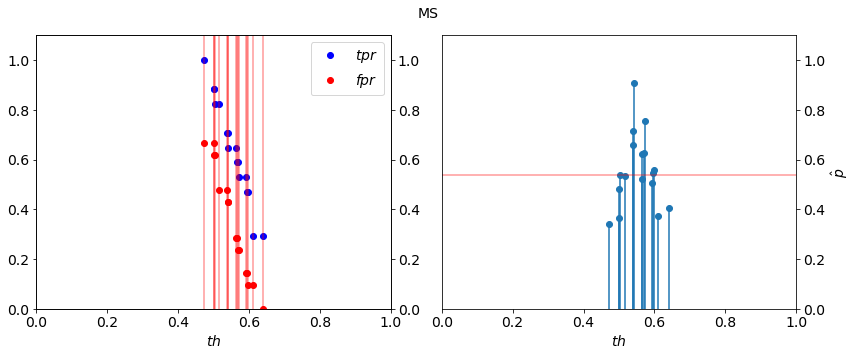

In [425]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(12, 5)
fontsize = 14
alpha = 0.4

tpr_plot = ax1.plot(
    ths,
    tprs,
    'o',
    color = 'b',
    label=r'$tpr$',
)
ax1b = ax1.twinx()
fpr_plot = ax1b.plot(
    ths,
    fprs,
    'o',
    color = 'r',
    label=r'$fpr$',
)
ax1.set_xlabel(r'$th$', fontsize = fontsize)
ax1.tick_params(labelsize = fontsize)
ax1b.tick_params(labelsize = fontsize)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.1])
ax1b.set_ylim([0, 1.1])
h1, l1 = ax1.get_legend_handles_labels()
h1b, l1b = ax1b.get_legend_handles_labels()
ax1.vlines(
    ths,
    ymin=0,
    ymax=1.1,
    alpha=alpha,
    color='r',
)
ax1.legend(h1+h1b, l1+l1b, loc='best', fontsize=fontsize)

ax2.stem(
    ths,
    hat_p_vs_th,
    basefmt=" ",
)
ax2.plot(
    [0, 1.0],
    [hat_p_ms, hat_p_ms],
    alpha=alpha,
    color='r',
)
ax2.set_xlabel(r'$th$', fontsize = fontsize)
ax2.set_ylabel(r'$\hat p$', fontsize = fontsize)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.1])
ax2.tick_params(labelsize = fontsize)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

f.suptitle('MS', fontsize = fontsize)
f.tight_layout()
plt.savefig(f'{output_dir}/seleccion_umbrales_ms.png')
plt.show()

In [426]:
hat_p_dict

{'MAX': 0.5073691967575534,
 'X': 0.5226645644461964,
 'T50': 0.5590690614722996,
 'MS': 0.5368005572324122}

In [427]:
classif_predictions = qp.data.LabelledCollection(y_predict_proba_c[:, 1], y_c)
qp_tr_data = classif_predictions

qp_methods = {'MAX': TH_MAX, 'X': TH_X, 'T50': TH_T50, 'MS': TH_MS}
hat_p_qp = {}

for key, func in qp_methods.items():
    qp_method = func(model)
    qp_method.aggregation_fit(classif_predictions, qp_tr_data)
    hat_p_qp[key] = qp_method.aggregate(y_predict_proba_test[:, 1])[1]

hat_p_qp


{'MAX': 0.5073691967575534,
 'X': 0.5042372881355933,
 'T50': 0.5590690614722996,
 'MS': 0.5550847457627118}

In [428]:
#EMQ
## Necesita dataset para calibrar (no ajusta para cuantificar, pero necesita el set de entrenamiento)
### Creo nuevo modelo con 85% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_ab, y_ab)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_c, y_c)
y_predict_test = model.predict(X_test)
y_predict_proba_test = model.predict_proba(X_test)
y_predict_proba_train = model.predict_proba(X_train)
print(y_predict_proba_test[:, 1].mean())
print(y_predict_proba_test[0, 1].mean())
### Cuantifico con QuaPy
classif_predictions = qp.data.LabelledCollection(y_predict_proba_test, y_test)
qp_tr_data = qp.data.LabelledCollection(y_predict_proba_train, y_train)
qp_emq = EMQ(model)
qp_emq.aggregation_fit(classif_predictions, qp_tr_data)
{
    'hat_p_emq_qp': qp_emq.aggregate(y_predict_proba_test)[1],
}

0.4591418072300529
0.6928431552247089


{'hat_p_emq_qp': 0.14300212335609605}

In [429]:
#HDy
## Necesita dataset para cuantificar y para calibrar
### Creo nuevo modelo con 60% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_a, y_a)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_b, y_b)
### Ajusto modelo cuantificador con el 15%
#### Con QuaPy
y_predict_c = model.predict(X_c)
y_predict_proba_c = model.predict_proba(X_c)
classif_predictions = qp.data.LabelledCollection(y_predict_proba_c, y_c)
qp_tr_data = classif_predictions
qp_hdy = HDy(model)
qp_hdy.aggregation_fit(classif_predictions, qp_tr_data)
#### Cuantifico
hat_p_hdy_qp = qp_hdy.aggregate(y_predict_proba_test)[1]
{
    'hat_p_hdy_qp': hat_p_hdy_qp,
}

{'hat_p_hdy_qp': 0.47000000000000003}

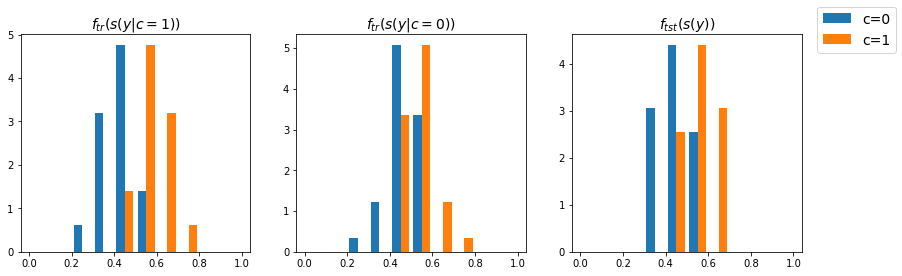

In [430]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(14, 4)
fontsize = 14
alpha = 0.4

y_predict_proba_train = model.predict_proba(X_train)
y_predict_proba_test = model.predict_proba(X_test)

counts_1, bins_1, bars_1 = ax1.hist(y_predict_proba_train[y_train==1], bins=10, range=(0,1), density=True, label=("c=0", "c=1"))
ax1.set_title(r"$f_{tr}{(s(y|c=1)})$", fontsize=fontsize)
counts_2, bins_2, bars_2 = ax2.hist(y_predict_proba_train[y_train==0], bins=10, range=(0,1), density=True)
ax2.set_title(r"$f_{tr}{(s(y|c=0)})$", fontsize=fontsize)
counts_3, bins_3, bars_3 = ax3.hist(y_predict_proba_test, bins=10, range=(0,1), density=True)
ax3.set_title(r"$f_{tst}{(s(y)})$", fontsize=fontsize)

handles, labels = ax1.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=fontsize)
plt.savefig(f'{output_dir}/hdy_1.png')
plt.show()

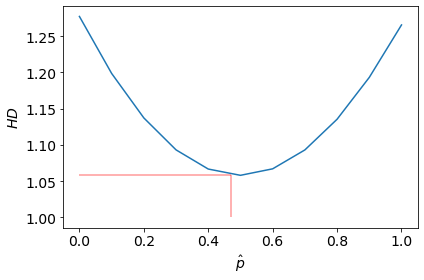

In [431]:
ps = np.linspace(0, 1, 11)
hds = [None] * len(ps)
for idx, p in enumerate(ps):
    merged = counts_1*p+counts_2*(1-p)
    hds[idx] = HellingerDistance(merged, counts_3)
plt.plot(ps, hds)
plt.xlabel(r'$\hatp$', fontsize = fontsize)
plt.ylabel(r'$\it{HD}$', fontsize = fontsize)
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.vlines(
    hat_p_hdy_qp,
    ymin=1.0,
    ymax=hds[5],
    alpha=alpha,
    color='r',
)
plt.hlines(
    hds[5],
    xmin=0.0,
    xmax=hat_p_hdy_qp,
    alpha=alpha,
    color='r',
)
fig.tight_layout()
fig.savefig(f'{output_dir}/hdy_2.png')
plt.show()

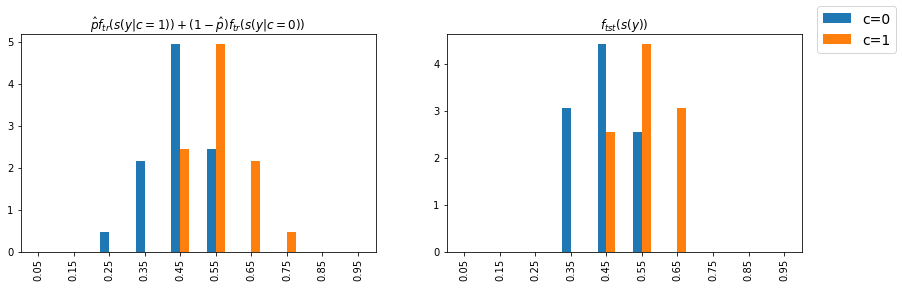

In [432]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(14, 4)
fontsize = 14
alpha = 0.4

p = hat_p_hdy_qp
merged = counts_1*p+counts_2*(1-p)
bins_aux = np.round((bins_1[:-1]+0.05),2)
pd_merged = pd.DataFrame(index=bins_aux, data={"c=0": merged[0], "c=1": merged[1]})
pd_merged.plot(kind='bar', ax=ax1, title=r"$\hat{p} f_{tr}{(s(y|c=1))}+(1-\hat{p}) f_{tr}{(s(y|c=0))}$", legend=False)

pd_merged = pd.DataFrame(index=bins_aux, data={"c=0": counts_3[0], "c=1": counts_3[1]})
pd_merged.plot(kind='bar', ax=ax2, title=r"$f_{tst}{(s(y)})$", legend=False)

handles, labels = ax1.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=fontsize)
plt.savefig(f'{output_dir}/hdy_3.png')
plt.show()

In [433]:
#ELM
## Con clasificador específico, no usa clasificador previo
qp.environ['SVMPERF_HOME'] = '/home/max/my_projects/QuaPy/svm_perf_quantification'
qp_svmkld = newELM(qp.environ['SVMPERF_HOME'], loss='kld')
qp_data_train = qp.data.LabelledCollection(X_train, y_train)
qp_svmkld.fit(qp_data_train)
### Cuantifico
#### Con QuaPy
hat_p_svmkld_qp = qp_svmkld.quantify(X_test)[1]
### Resultados
print({
    'hat_p_svmkld_qp': hat_p_svmkld_qp,
})

qp.environ["SAMPLE_SIZE"] = len(y_test)

print(r'$KLD_{CC}:$', kld(np.array([0.9, 0.1]), np.array([1-hat_p_cc_qp, hat_p_cc_qp])))
print(r'$KLD_{SVM_{perfKL}}:$', kld(np.array([0.9, 0.1]), np.array([1-hat_p_svmkld_qp, hat_p_svmkld_qp])))

{'hat_p_svmkld_qp': 0.4745762711864407}
$KLD_{CC}:$ 0.5253804886280824
$KLD_{SVM_{perfKL}}:$ 0.3208918402054848
